In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical 

import shap

from sklearn import metrics

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


In [2]:
df_err = pd.DataFrame()

In [30]:
#Переносим предсказываемую колонку в начало для удобства
db_final1 = pd.read_excel('final_db_np.xlsx')
db_final = db_final1.drop(columns=['viability_%', 'Unnamed: 0', 'electronegativity'])
db_final.insert(0, 'viability_%', db_final1['viability_%'])

In [31]:
#Разбиваем на тестовые и тренировочные выборки базу данных
y = db_final.loc[:,'viability_%'].values
x = db_final.loc[:,'size_nm':].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

#Масштабируем данные 
sc = MinMaxScaler(feature_range=(0, 1))
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [32]:
#Введем функцию для построения графиков
def regr_plot(y_train, y_test, y_pred, y1_pred):
    f, ax = plt.subplots(figsize=(15, 10))
    plt.scatter(y_train, y1_pred, color='#F7D3BA', s=70)
    plt.scatter(y_test, y_pred, color='#E6E7E5',s=70)
    plt.plot(y_test, y_test, color='#A6AA9C')
    plt.xlabel('Test data', fontsize=18)
    plt.ylabel('Predicted data', fontsize=18)
    plt.xlim(-10, 140)
    plt.ylim(-30, 140)

In [33]:
#Введем функцию для расчета метрик
def regr_metrics(regr, x_train, y_train, y_test, y_pred, y1_pred):
    Q2 = cross_val_score(regr, x_train, y_train, cv=10).mean()
    R2 = metrics.r2_score(y_test, y_pred)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Q2:', Q2)
    print('r2_test:', R2)
    print('MAE_test:', MAE)
    print('MSE_test:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE_test:', RMSE)
    print('r2_train:', metrics.r2_score(y_train, y1_pred))
    print('MAE_train:', metrics.mean_absolute_error(y_train, y1_pred))
    print('MSE_train:', metrics.mean_squared_error(y_train, y1_pred))
    print('RMSE_train:', np.sqrt(metrics.mean_squared_error(y_train, y1_pred)))
    return [Q2, R2, MAE, RMSE]

In [34]:
#Введем функцию Feature importance 
list_columns = ['size_nm', 'surface_charge_mV', 'cell_type', 
                'concentration_ug/mL', 'organic', 'time_h', 'animal', 'coating', 'test', 'cell_line', 'cell_morphology', 
                'molar_mass', 'electronegativity', 'charge_density']
def regr_feature(regr, x_test, list_columns):
    explainer = shap.TreeExplainer(regr)
    shap_values = explainer.shap_values(x_test)
    f, ax = plt.subplots(figsize=(15, 13))
    shap.summary_plot(shap_values, x_test, plot_type='bar', feature_names = list_columns, axis_color='#E6E7E5', title='Feature importance')

Q2: 0.11486907234737861
r2_test: 0.13943764213086807
MAE_test: 21.06995164926276
MSE_test: 737.9644089000767
RMSE_test: 27.165500343267684
r2_train: 0.11949933258288747
MAE_train: 21.476869340535387
MSE_train: 752.3179729976957
RMSE_train: 27.428415429945925


Text(0.5, 1.0, 'Linear Regression')

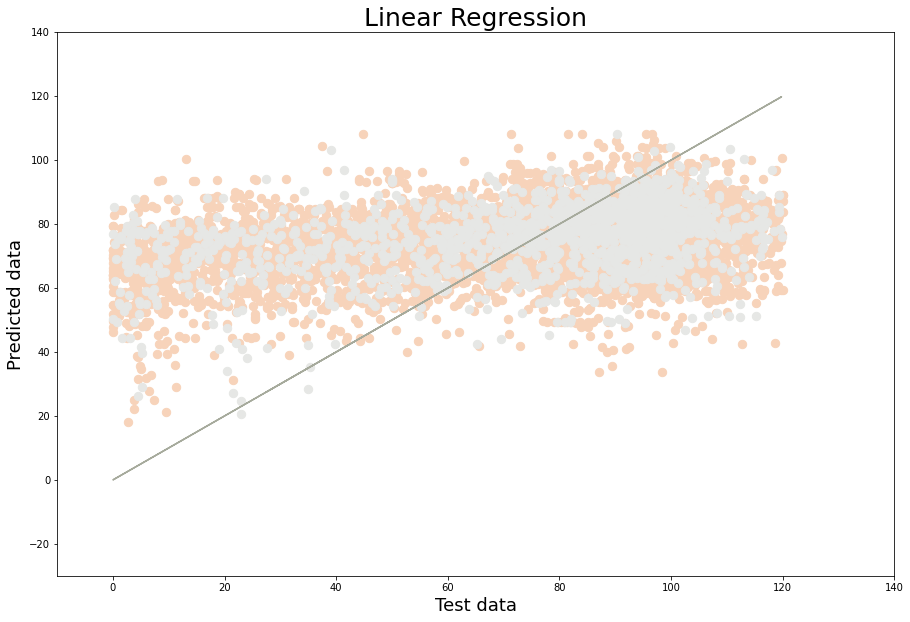

In [35]:
#LR
regr_LR = LinearRegression(fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=-1, positive=False)
regr_LR.fit(x_train,y_train)
y_pred=regr_LR.predict(x_test)
y1_pred = regr_LR.predict(x_train)

#Рассчитываем метрики
df_err['Linear Regression'] = regr_metrics(regr_LR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('Linear Regression', fontsize=25)

Q2: 0.7643256854231562
r2_test: 0.7905805644794477
MAE_test: 9.0416638013068
MSE_test: 179.58499873127613
RMSE_test: 13.400932756016505
r2_train: 0.9266373943728651
MAE_train: 5.231227290053406
MSE_train: 62.68252688681932
RMSE_train: 7.917229748265445


Text(0.5, 1.0, 'Gradient Boosting Regressor')

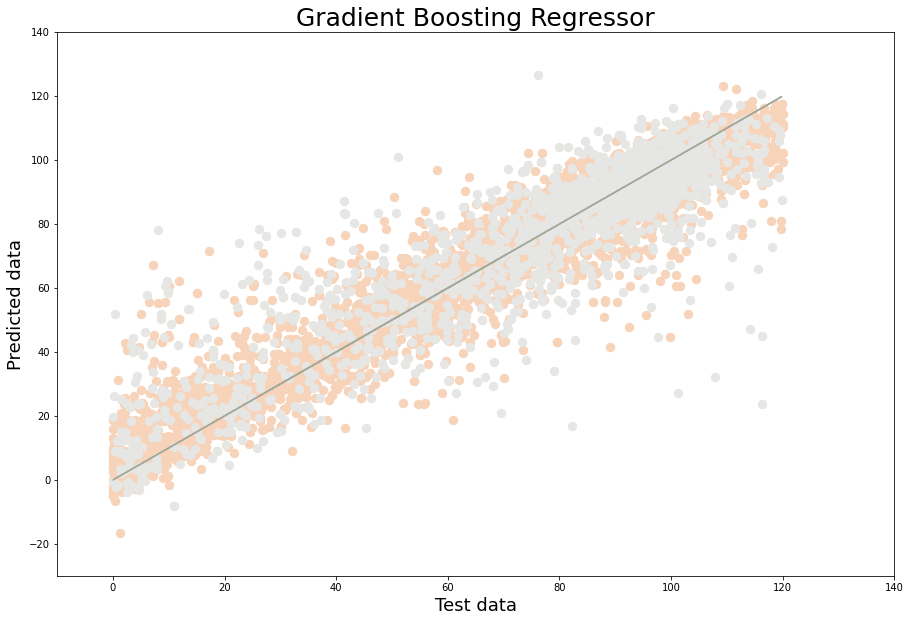

In [36]:
#GBR
regr_GBR = GradientBoostingRegressor(learning_rate=0.39, n_estimators=100, max_depth=8, min_samples_leaf=4, min_samples_split=30)
regr_GBR.fit(x_train, y_train)
y_pred = regr_GBR.predict(x_test)
y1_pred = regr_GBR.predict(x_train)

#Рассчитываем метрики
df_err['Gradient Boosting Regression'] = regr_metrics(regr_GBR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('Gradient Boosting Regressor', fontsize=25)


0:	learn: 22.7824574	total: 16.1ms	remaining: 2.4s
1:	learn: 20.4995517	total: 34ms	remaining: 2.51s
2:	learn: 19.2569705	total: 51.5ms	remaining: 2.52s
3:	learn: 18.1350622	total: 70.2ms	remaining: 2.56s
4:	learn: 17.2373914	total: 88.7ms	remaining: 2.57s
5:	learn: 16.8437137	total: 107ms	remaining: 2.58s
6:	learn: 16.0613616	total: 127ms	remaining: 2.6s
7:	learn: 15.5953508	total: 148ms	remaining: 2.62s
8:	learn: 15.0972019	total: 171ms	remaining: 2.68s
9:	learn: 14.6560489	total: 196ms	remaining: 2.75s
10:	learn: 14.3771225	total: 219ms	remaining: 2.77s
11:	learn: 13.9514774	total: 241ms	remaining: 2.77s
12:	learn: 13.4863727	total: 263ms	remaining: 2.77s
13:	learn: 13.2284598	total: 288ms	remaining: 2.8s
14:	learn: 12.9785129	total: 312ms	remaining: 2.81s
15:	learn: 12.7908708	total: 333ms	remaining: 2.79s
16:	learn: 12.5496776	total: 354ms	remaining: 2.77s
17:	learn: 12.3321108	total: 375ms	remaining: 2.75s
18:	learn: 12.0138522	total: 397ms	remaining: 2.73s
19:	learn: 11.7609407	

Text(0.5, 1.0, 'Cat Boost Regressor')

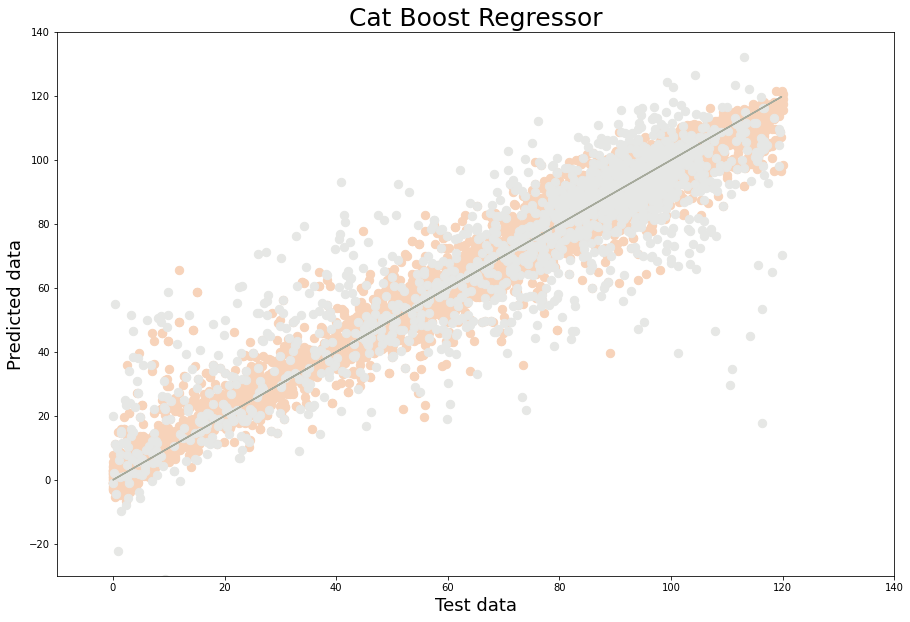

In [37]:
#CBR
regr_CBR = CatBoostRegressor(iterations=150, learning_rate=1, depth=10)
regr_CBR.fit(x_train, y_train)
y_pred = regr_CBR.predict(x_test)
y1_pred = regr_CBR.predict(x_train)

#Рассчитываем метрики
df_err['Cat Boosting Regression'] = regr_metrics(regr_CBR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('Cat Boost Regressor', fontsize=25)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Q2: 0.6155159862972046
r2_test: 0.6307245939928989
MAE_test: 11.195517996342554
MSE_test: 316.66747240739505
RMSE_test: 17.795153059397805
r2_train: 0.8769748098686891
MAE_train: 6.551511821288639
MSE_train: 105.11526577117172
RMSE_train: 10.252573616959388


Text(0.5, 1.0, 'Decision Tree Regressor')

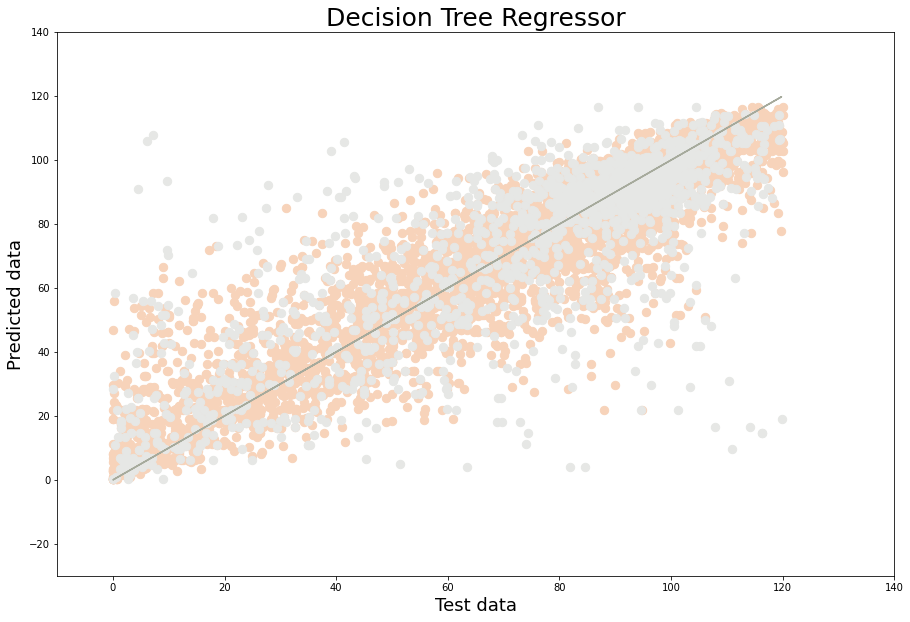

In [38]:
#DTR
regr_DTR = DecisionTreeRegressor(criterion='squared_error', max_depth=30, 
                                 min_samples_split=2, min_samples_leaf=3, max_features='auto')
regr_DTR.fit(x_train, y_train)
y_pred = regr_DTR.predict(x_test)
y1_pred = regr_DTR.predict(x_train)

#Рассчитываем метрики
df_err['Decision Tree Regression'] = regr_metrics(regr_DTR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('Decision Tree Regressor', fontsize=25)

In [12]:
#Проводим оптимизацию для RFR
regr_RFR = RandomForestRegressor()

search_space = {"n_estimators": Integer(100,150),
    "criterion": Categorical(['squared_error', 'absolute_error']),
    "min_samples_split": Integer(2, 30),
    "min_samples_leaf": Integer(1, 20),
    "max_depth": Integer(8, 20),
    "max_features": Categorical(['auto', 'sqrt'])}

opt_RFR = BayesSearchCV(estimator = regr_RFR, search_spaces=search_space, cv=3, n_iter=32, verbose=2, n_jobs=-1)
opt_RFR.fit(x_train, y_train)

n_esti = opt_RFR.best_estimator_.n_estimators
criterion = opt_RFR.best_estimator_.criterion
min_leaf = opt_RFR.best_estimator_.min_samples_leaf
min_split = opt_RFR.best_estimator_.min_samples_split
depth = opt_RFR.best_estimator_.max_depth
max_feat = opt_RFR.best_estimator_.max_features

print('n_esti:', n_esti,'depth:', depth, 'criterion:', criterion, 'min_leaf:', min_leaf,'min_split:', min_split,'max_feat:', max_feat)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


The objective has been evaluated at this point before.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


n_esti: 150 depth: 19 criterion: squared_error min_leaf: 1 min_split: 2 max_feat: auto


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Q2: 0.7402442506685508
r2_test: 0.7677345724833535
MAE_test: 9.621740236418267
MSE_test: 199.1762913609934
RMSE_test: 14.112983078038228
r2_train: 0.89264772748156
MAE_train: 6.71331214090176
MSE_train: 91.72400095355049
RMSE_train: 9.577264795000215


Text(0.5, 1.0, 'Random Forest Regression')

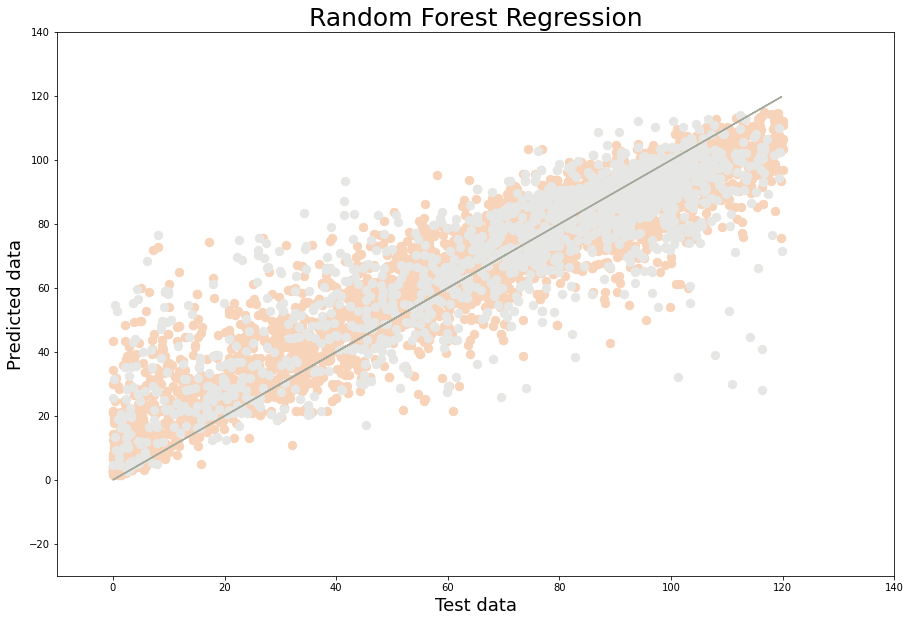

In [39]:
#RFR
regr_RFR = RandomForestRegressor(n_estimators=n_esti, max_depth=depth, min_samples_leaf=min_leaf, 
                                 min_samples_split=min_split, criterion=criterion, max_features=max_feat)
regr_RFR.fit(x_train, y_train)
y_pred = regr_RFR.predict(x_test)
y1_pred = regr_RFR.predict(x_train)

#Рассчитываем метрики
df_err['Random Forest Regression'] = regr_metrics(regr_RFR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('Random Forest Regression', fontsize=25)

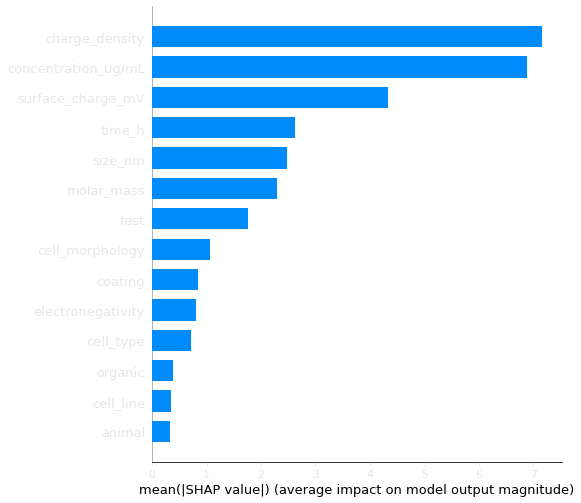

In [14]:
regr_feature(regr_RFR, x_test, list_columns)

In [19]:
#Проводим оптимизацию для XGBR
regr_XGBR = XGBRegressor()

search_space = {"verbosity": Integer(1, 3),
    "max_depth": Integer(8, 13),
    "min_child_weight": Integer(0, 5),
    "max_delta_step": Integer(0, 5),
    "subsample": Real(0.1, 1.0)}

opt_XGBR = BayesSearchCV(estimator = regr_XGBR, search_spaces=search_space)
opt_XGBR.fit(x_train, y_train)

verbosity = opt_XGBR.best_estimator_.verbosity
depth = opt_XGBR.best_estimator_.max_depth
weight = opt_XGBR.best_estimator_.min_child_weight
step = opt_XGBR.best_estimator_.max_delta_step
subsample = opt_XGBR.best_estimator_.subsample

print('verbosity:', verbosity, 'depth:', depth, 'subsample:', subsample, 'min_child_weight', weight, 'max_delta_step:', step)

[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:32:58] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

The objective has been evaluated at this point before.


[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:33:43] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


[20:35:45] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:35:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:35:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:35:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:35:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:35:45] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:35:45] INFO: C:/Users/A

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


[20:36:23] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:23] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:23] INFO: C:/Users/A

The objective has been evaluated at this point before.


[20:36:30] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:30] INFO: C:/Users/A

The objective has been evaluated at this point before.


[20:36:37] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:36:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:37] INFO: C:/Users/A

The objective has been evaluated at this point before.


[20:36:44] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:36:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:44] INFO: C:/Users/A

The objective has been evaluated at this point before.


[20:36:50] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:36:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:50] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:36:50] INFO: C:/Users/A

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


[20:37:44] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:155: Using tree method: 2
[20:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:37:44] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[20:37:44] INFO: C:/Users/A

Q2: 0.8015273053278277
r2_test: 0.8171297513597737
MAE_test: 8.234488117609073
MSE_test: 156.8180779802561
RMSE_test: 12.522702503064428
r2_train: 0.9621565165824024
MAE_train: 3.5410195112642957
MSE_train: 32.334254577471995
RMSE_train: 5.6863217089320575


Text(0.5, 1.0, 'XGBRegressor')

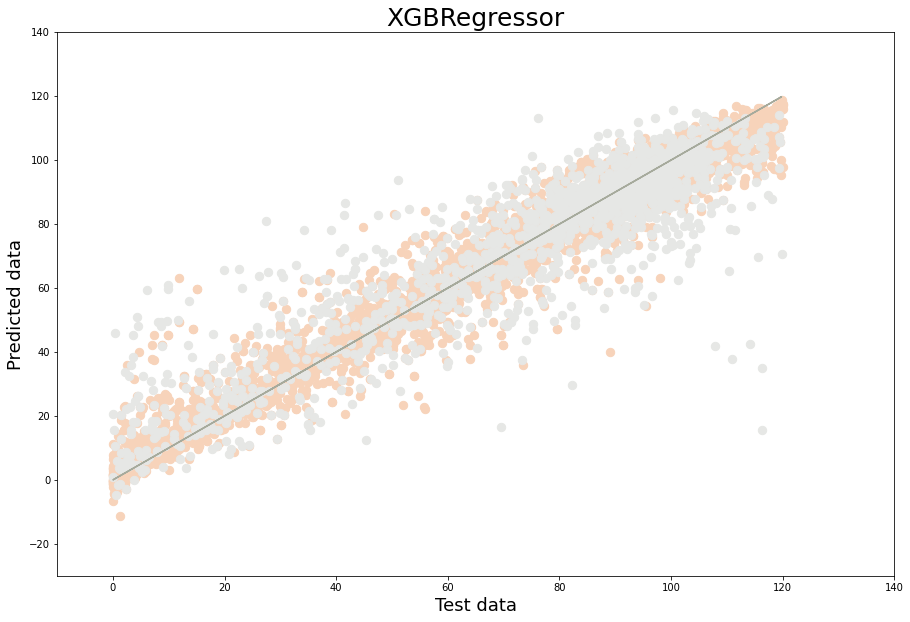

In [40]:
#XGBR
regr_XGBR = XGBRegressor(booster='gbtree', verbosity= verbosity, nthread= 2, eta= 0.15, gamma= 0, max_depth= depth, 
                         min_child_weight= weight, subsample= subsample)
regr_XGBR.fit(x_train, y_train)
y_pred = regr_XGBR.predict(x_test)
y1_pred = regr_XGBR.predict(x_train)

#Рассчитываем метрики
df_err['XGB Regression'] = regr_metrics(regr_XGBR, x_train, y_train, y_test, y_pred, y1_pred)

#Строим график
regr_plot(y_train, y_test, y_pred, y1_pred)
plt.title('XGBRegressor', fontsize=25)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


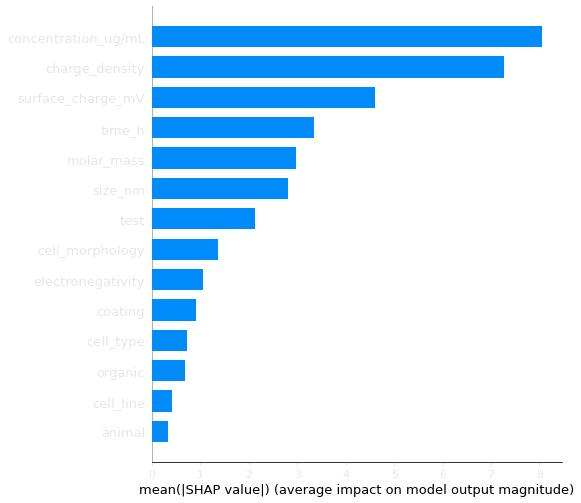

In [17]:
regr_feature(regr_XGBR, x_test, list_columns)

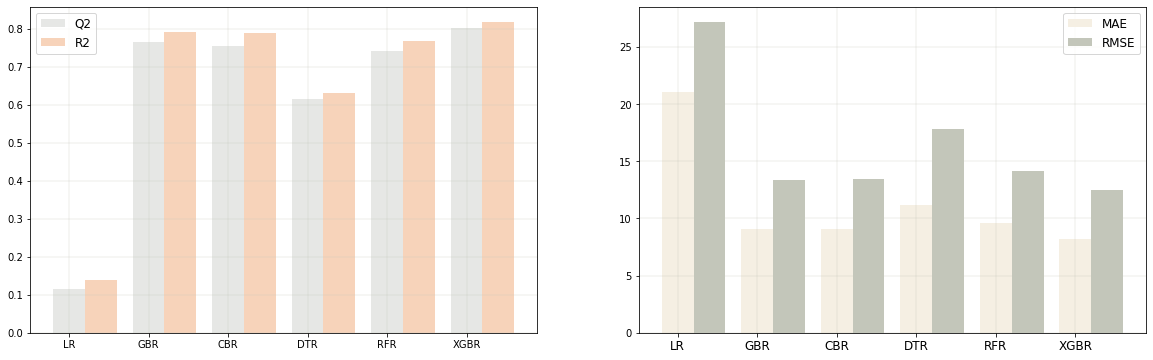

In [41]:
#Построим график, который поможет сравнить методы по основным метрикам
df_err1 = df_err.transpose()

barWidth = 0.4
x = ['LR', 'GBR', 'CBR', 'DTR', 'RFR', 'XGBR']
br1 = np.arange(len(x))
br2 = [x + barWidth for x in br1]
br3 =  np.arange(len(x))
br4 = [x + barWidth for x in br3]

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20, 6))

ax1.bar(br1, df_err1[0], color ='#E6E7E5', width = barWidth, label ='Q2')
ax1.bar(br2, df_err1[1], color ='#F7D3BA', width = barWidth, label ='R2')

ax2.bar(br3, df_err1[2], color ='#F5EFE3', width = barWidth, label ='MAE')
ax2.bar(br4, df_err1[3], color ='#C3C6BA', width = barWidth, label ='RMSE')

plt.xticks(br1, ['LR', 'GBR', 'CBR', 'DTR', 'RFR', 'XGBR'], fontsize = 12)
        
ax1.grid(color='#C3C6BA', linewidth=0.3)
ax2.grid(color='#C3C6BA', linewidth=0.3)
 
ax1.legend(fontsize = 12)
ax2.legend(fontsize = 12)